In [1]:
import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

img_wh = (200, 200)

In [2]:
# Change to your settings...
############################
encode_appearance = True
N_a = 48
encode_transient = False
N_tau = 16
beta_min = 0.1
ckpt_path = 'ckpts/lego_nerfa_color/epoch=19.ckpt'

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(9, 10)
embedding_dir = PosEmbedding(3, 4)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(100, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(100, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse').cuda()
nerf_fine = NeRF('fine',
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [3]:
@torch.no_grad()
def f(rays, ts):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on (perturbed) train images

In [4]:
perturbation = ['color']

dataset = dataset_dict['blender'] \
          ('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/',
           split='test_train',
           perturbation=perturbation,
           img_wh=img_wh)

In [5]:
# sample an image ...
# 0 is unperturbed, others are perturbed
sample = dataset[50]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

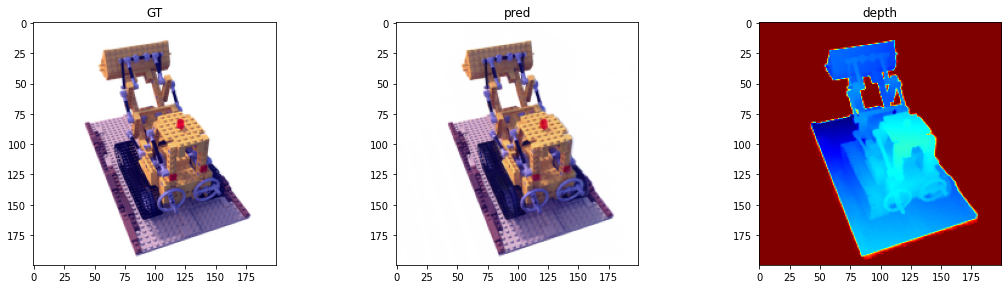

PSNR between GT and pred: 31.892902374267578 



In [6]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')

# Test on 63th val image (same as the image in the paper Fig 13)

In [7]:
perturbation = ['color']

dataset = dataset_dict['blender'] \
          ('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/',
           split='val',
           perturbation=perturbation,
           img_wh=img_wh)

In [8]:
sample = dataset[63]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

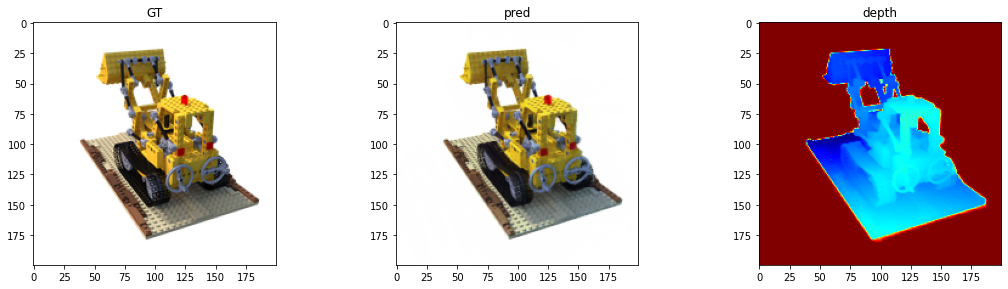

PSNR between GT and pred: 28.836572647094727 



In [9]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')